In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import lightgbm as lgb

In [2]:
# 读入数据
data = pd.read_csv('./data/airline-passengers.csv',parse_dates=[0])
data

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [3]:
import datetime 
def convertTime(t):
    d = t.date()
    return pd.Series({"year":d.year,"month":d.month,"month_str":str(d.month)})
data =data.merge(data['Month'].apply(convertTime), left_index=True, right_index=True)
data =data.rename(columns={"Passengers":"count"})
data.head()

,Month,count,year,month,month_str
0,1949-01-01,112,1949,1,1
1,1949-02-01,118,1949,2,2
2,1949-03-01,132,1949,3,3
3,1949-04-01,129,1949,4,4
4,1949-05-01,121,1949,5,5


In [4]:
# Create Training and Test
train_size= int(len(data)*0.95)
test_size= len(data) -train_size
train = data[:train_size].copy()
test_bak = data[train_size:].copy()
data_x = data.copy()

In [5]:
# 过去12个月进行预测
cols=['count']
for j in range(1,12):
    train['count-'+str(j)]=train['count'].shift(j)
    data_x['count-'+str(j)]=data_x['count'].shift(j)
train.head()

,Month,count,year,month,month_str,count-1,count-2,count-3,count-4,count-5,count-6,count-7,count-8,count-9,count-10,count-11
0,1949-01-01,112,1949,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1949-02-01,118,1949,2,2,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1949-03-01,132,1949,3,3,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1949-04-01,129,1949,4,4,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1949-05-01,121,1949,5,5,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
train.tail()

,Month,count,year,month,month_str,count-1,count-2,count-3,count-4,count-5,count-6,count-7,count-8,count-9,count-10,count-11
131,1959-12-01,405,1959,12,12,362.0,407.0,463.0,559.0,548.0,472.0,420.0,396.0,406.0,342.0,360.0
132,1960-01-01,417,1960,1,1,405.0,362.0,407.0,463.0,559.0,548.0,472.0,420.0,396.0,406.0,342.0
133,1960-02-01,391,1960,2,2,417.0,405.0,362.0,407.0,463.0,559.0,548.0,472.0,420.0,396.0,406.0
134,1960-03-01,419,1960,3,3,391.0,417.0,405.0,362.0,407.0,463.0,559.0,548.0,472.0,420.0,396.0
135,1960-04-01,461,1960,4,4,419.0,391.0,417.0,405.0,362.0,407.0,463.0,559.0,548.0,472.0,420.0


In [7]:
target_cols = []
for i in range(1,test_size+1): # 预测未来test_size个时间周期
    t = 'count+'+str(i)
    target_cols.append(t)
    train[t] = train['count'].shift(-i)
    data_x[t] = data_x['count'].shift(-i)
train.tail()

,Month,count,year,month,month_str,count-1,count-2,count-3,count-4,count-5,...,count-10,count-11,count+1,count+2,count+3,count+4,count+5,count+6,count+7,count+8
131,1959-12-01,405,1959,12,12,362.0,407.0,463.0,559.0,548.0,...,342.0,360.0,417.0,391.0,419.0,461.0,NaN,NaN,NaN,NaN
132,1960-01-01,417,1960,1,1,405.0,362.0,407.0,463.0,559.0,...,406.0,342.0,391.0,419.0,461.0,NaN,NaN,NaN,NaN,NaN
133,1960-02-01,391,1960,2,2,417.0,405.0,362.0,407.0,463.0,...,396.0,406.0,419.0,461.0,NaN,NaN,NaN,NaN,NaN,NaN
134,1960-03-01,419,1960,3,3,391.0,417.0,405.0,362.0,407.0,...,420.0,396.0,461.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135,1960-04-01,461,1960,4,4,419.0,391.0,417.0,405.0,362.0,...,472.0,420.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# train =train.dropna().reset_index(drop=True)
# test=test.dropna().reset_index(drop=True)
# print(len(train),len(test))

In [9]:
print(f'train_size={train_size},test_size={test_size}')
data_x.loc[train_size,:]


train_size=136,test_size=8


Month        1960-05-01 00:00:00
count                        472
year                        1960
month                          5
month_str                      5
count-1                    461.0
count-2                    419.0
count-3                    391.0
count-4                    417.0
count-5                    405.0
count-6                    362.0
count-7                    407.0
count-8                    463.0
count-9                    559.0
count-10                   548.0
count-11                   472.0
count+1                    535.0
count+2                    622.0
count+3                    606.0
count+4                    508.0
count+5                    461.0
count+6                    390.0
count+7                    432.0
count+8                      NaN
Name: 136, dtype: object

In [10]:
data_x.loc[train_size,:]

Month        1960-05-01 00:00:00
count                        472
year                        1960
month                          5
month_str                      5
count-1                    461.0
count-2                    419.0
count-3                    391.0
count-4                    417.0
count-5                    405.0
count-6                    362.0
count-7                    407.0
count-8                    463.0
count-9                    559.0
count-10                   548.0
count-11                   472.0
count+1                    535.0
count+2                    622.0
count+3                    606.0
count+4                    508.0
count+5                    461.0
count+6                    390.0
count+7                    432.0
count+8                      NaN
Name: 136, dtype: object

In [11]:
# target_cols = ['count_'+str(i) for i in range(1,15)]
feats_cols = [col for col in train.columns if col not in target_cols+["Month"]]
target_cols,feats_cols

(['count+1',
  'count+2',
  'count+3',
  'count+4',
  'count+5',
  'count+6',
  'count+7',
  'count+8'],
 ['count',
  'year',
  'month',
  'month_str',
  'count-1',
  'count-2',
  'count-3',
  'count-4',
  'count-5',
  'count-6',
  'count-7',
  'count-8',
  'count-9',
  'count-10',
  'count-11'])

In [12]:
test_x = data_x[data_x["Month"]==data_x.loc[train_size-1,"Month"]]
test_x

,Month,count,year,month,month_str,count-1,count-2,count-3,count-4,count-5,...,count-10,count-11,count+1,count+2,count+3,count+4,count+5,count+6,count+7,count+8
135,1960-04-01,461,1960,4,4,419.0,391.0,417.0,405.0,362.0,...,472.0,420.0,472.0,535.0,622.0,606.0,508.0,461.0,390.0,432.0


In [13]:
def filter_unused(feats_cols,target_col):
    """过滤掉count+2 日期之后的字段，这些字段肯定是无关的
    """
    num = int(target_col.split('+')[1])
    new_feature_cols = []
    for x in feats_cols:
        if x.find('+')>=0:
           _num = int(x.split('+')[1]) 
           if num < _num:
               continue
        new_feature_cols.append(x)
    return new_feature_cols
print(filter_unused(feats_cols,'count+2'))

['count', 'year', 'month', 'month_str', 'count-1', 'count-2', 'count-3', 'count-4', 'count-5', 'count-6', 'count-7', 'count-8', 'count-9', 'count-10', 'count-11']


In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
# def run_lgb(df_train, df_test,target,col):
# #     model = lgb.LGBMRegressor(n_estimators=100000,random_state=1212,categorical_feature=categorical_feature_list)
#     model = lgb.LGBMRegressor(num_leaves= 50,
# #                               max_depth=6,
#                               n_estimators=1000,
#                               random_state=1212,
#                               learning_rate = 0.01,
#                              )
#     oof = np.zeros(df_train.shape[0])
#     preds = np.zeros(df_test.shape[0])
#     fold_k  = 5
#     kfold = KFold(n_splits=fold_k,shuffle=True, random_state=1212)
#     # https://lightgbm.readthedocs.io/en/latest/Python-Intro.html
#     def get_categorical_feature(df):
#         feature_names = []
#         categorical_feature = []
#         for i,t in df.dtypes.items():
#             feature_names.append(i)
# #             print(i,t,type(t),str(t))
#             if str(t) =='object' or str(t)=='category':
#                 df[i] = df[i].astype('int')
#                 categorical_feature.append(i)
#         return feature_names,categorical_feature
#     get_categorical_feature(df_test)
#     feature_name,categorical_feature = get_categorical_feature(df_train)
#     for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(df_train,target)):
#         X_train = df_train.iloc[trn_idx]
#         Y_train = target.iloc[trn_idx][col]
#         X_val = df_train.iloc[val_idx]
#         Y_val = target.iloc[val_idx][col]
# #         print(f'X_train.shape={X_train.shape},Y_train.shape={Y_train.shape}')
# #         print(f'X_val.shape={X_val.shape},Y_val.shape={Y_val.shape}')
#         lgb_model = model.fit(X_train, 
#                               Y_train,
#                               eval_names=['train', 'valid'],
#                               eval_set=[(X_train, Y_train), (X_val, Y_val)],
#                               verbose=0,
#                               feature_name = feature_name,
#                               categorical_feature = categorical_feature,
#                               eval_metric='mse',
#                               early_stopping_rounds=50)
#         oof[val_idx] = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration_)
# #         print(f'preds.shape={preds.shape}')
# #         print(df_test)
#         preds += lgb_model.predict(df_test, num_iteration=lgb_model.best_iteration_)/fold_k
#     score = mean_squared_error(oof, target[col]) 
# #     print(f'oof.shape={oof.shape},preds.shape={preds.shape}')
#     return oof, preds,score


def run_lgbm2(df_train, df_test,target,col):
    def get_categorical_feature(df):
        feature_names = []
        categorical_feature = []
        for i,t in df.dtypes.items():
            feature_names.append(i)
#             print(i,t,type(t),str(t))
            if str(t) =='object' or str(t)=='category':
                df[i] = df[i].astype('int')
                categorical_feature.append(i)
        return feature_names,categorical_feature
    
    feature_name,categorical_feature = get_categorical_feature(df_train)
    get_categorical_feature(df_test)
    y_train = target.iloc[:][col]
    params = {
    'boosting_type': 'gbdt', 
    'objective': 'regression', 
    'learning_rate': 0.001, 
    'num_leaves': 8, 
    'max_depth': 3,
     "verbose":-1,
        "metric":'rmse',
    "first_metric_only":True
#     'subsample': 0.8, 
#     'colsample_bytree': 0.8, 
    }

    data_train = lgb.Dataset(df_train, y_train, silent=True,
                             feature_name = feature_name,
                          categorical_feature = categorical_feature
                            )
    cv_results = lgb.cv(
        params, data_train, num_boost_round=1000, nfold=5, stratified=False, shuffle=True, metrics='rmse',
        early_stopping_rounds=50, verbose_eval=5000, show_stdv=False, seed=0)
#     print('best n_estimators:', len(cv_results['rmse-mean']))
#     print('best cv score:', cv_results['rmse-mean'][-1])
    n_estimators = len(cv_results['rmse-mean']) 
    
    from sklearn.model_selection import GridSearchCV
    ### 我们可以创建lgb的sklearn模型，使用上面选择的(学习率，评估器数目)
    model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=50,
                                  learning_rate=0.1, n_estimators=n_estimators, max_depth=6,
                                  metric='rmse', bagging_fraction = 0.8,feature_fraction = 1)

    params_test1={
        'max_depth': range(2,4,1), # 3,5,7
        'num_leaves':range(4,13, 1) # 20,30,40,50

    }
    gsearch1 = GridSearchCV(estimator=model_lgb, param_grid=params_test1, scoring='neg_mean_squared_error', cv=5, verbose=-1, n_jobs=4)
    gsearch1.fit(df_train, y_train)
#     print(gsearch1)
#     print(gsearch1.best_params_, gsearch1.best_score_)
    max_depth = gsearch1.best_params_['max_depth']                      
    num_leaves = gsearch1.best_params_['num_leaves'] 
    m = gsearch1.best_estimator_
#     print(m,m.best_iteration_)
    oof = m.predict(df_train, num_iteration=m.best_iteration_)
    preds = m.predict(df_test, num_iteration=m.best_iteration_)
    score = mean_squared_error(oof, target[col]) 
    print(f'{col},best params:n_estimators={n_estimators},max_depth={max_depth},num_leaves={num_leaves},score={gsearch1.best_score_}')
#     print(f'oof.shape={oof.shape},preds.shape={preds.shape}')
    return oof, preds,score

import warnings
warnings.filterwarnings('ignore')
scores1=[]
sub=pd.DataFrame()
s=0

scores2=[]
#     print(feats_cols,t_id,test_x)
#     print(target_cols)
for col in target_cols[:]:
    feats_cols_after_filter =filter_unused(feats_cols,col)
    train_x = train[feats_cols_after_filter+[col]]
    train_x = train_x.dropna().reset_index(drop=True)
    print(f'{col} model, train_len={len(train_x)}')
    y_id = train_x[[col]]
    x_id = train_x[feats_cols_after_filter]
    t_id = test_x[feats_cols_after_filter]
    oof, preds, score=run_lgbm2(x_id, t_id, y_id,col)
    test_x[col]=preds
    scores2.append(score)
sub = pd.concat([sub,test_x],axis=0)
#     print(x_id.shape,t_id.shape,y_id.shape)
print(s,np.mean(scores2))

count+1 model, train_len=124
count+1,best params:n_estimators=1000,max_depth=3,num_leaves=4,score=-1718.8163639735121
count+2 model, train_len=123
count+2,best params:n_estimators=1000,max_depth=3,num_leaves=4,score=-1324.4729699199322
count+3 model, train_len=122
count+3,best params:n_estimators=1000,max_depth=3,num_leaves=4,score=-1435.1098893375818
count+4 model, train_len=121
count+4,best params:n_estimators=1000,max_depth=3,num_leaves=4,score=-1604.5361615163206
count+5 model, train_len=120
count+5,best params:n_estimators=1000,max_depth=3,num_leaves=4,score=-1365.5971727190129
count+6 model, train_len=119
count+6,best params:n_estimators=1000,max_depth=3,num_leaves=4,score=-1871.2848699411193
count+7 model, train_len=118
count+7,best params:n_estimators=1000,max_depth=2,num_leaves=4,score=-2114.0200608442174
count+8 model, train_len=117
count+8,best params:n_estimators=1000,max_depth=3,num_leaves=4,score=-1741.9822796329518
0 21.923802785179692


In [15]:
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import KFold
# def run_lgb(df_train, df_test,target,col):
#     model = lgb.LGBMRegressor(n_estimators=100000,random_state=300)
#     oof = np.zeros(df_train.shape[0])
#     preds = np.zeros(df_test.shape[0])
    
#     kfold = KFold(n_splits=5,shuffle=True, random_state=300)
#     for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(df_train,target)):
        
#         X_train = df_train.iloc[trn_idx]
#         Y_train = target.iloc[trn_idx][col]
#         X_val = df_train.iloc[val_idx]
#         Y_val = target.iloc[val_idx][col]
#         lgb_model = model.fit(X_train, 
#                               Y_train,
#                               eval_names=['train', 'valid'],
#                               eval_set=[(X_train, Y_train), (X_val, Y_val)],
#                               verbose=0,
#                               eval_metric='mse',
#                               early_stopping_rounds=50)
#         oof[val_idx] = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration_)
# #         print(df_test)
#         preds += lgb_model.predict(df_test, num_iteration=lgb_model.best_iteration_)/5
#     score = mean_squared_error(oof, target[col]) 
#     return oof, preds,score

# import warnings
# warnings.filterwarnings('ignore')
# scores1=[]
# sub=pd.DataFrame()
# s=0

# ##  
# x_id = train[feats_cols]
# t_id = test_x[feats_cols]
# #     print(feats_cols,t_id,test_x)
# y_id = train[target_cols]
# for col in target_cols:
#     oof, preds, score=run_lgb(x_id, t_id, y_id,col)
#     test_x[col]=preds
#     scores1.append(score)
# sub = pd.concat([sub,test_x],axis=0)
# print(x_id.shape,t_id.shape,y_id.shape)
# # print(s,'------','admin_illness_name:',qid)
# print(np.mean(scores1))


In [20]:
sub

,Month,count,year,month,month_str,count-1,count-2,count-3,count-4,count-5,...,count-10,count-11,count+1,count+2,count+3,count+4,count+5,count+6,count+7,count+8
135,1960-04-01,461,1960,4,4,419.0,391.0,417.0,405.0,362.0,...,472.0,420.0,460.435573,495.610612,508.438118,525.909563,491.34114,481.501051,467.797711,465.184009


In [21]:
b=sub.loc[len(sub)-1:,target_cols].values.flatten()
test_bak.loc[:,'count']=b
b

array([460.43557334, 495.61061244, 508.43811774, 525.9095634 ,
       491.34113984, 481.50105075, 467.79771127, 465.18400863])

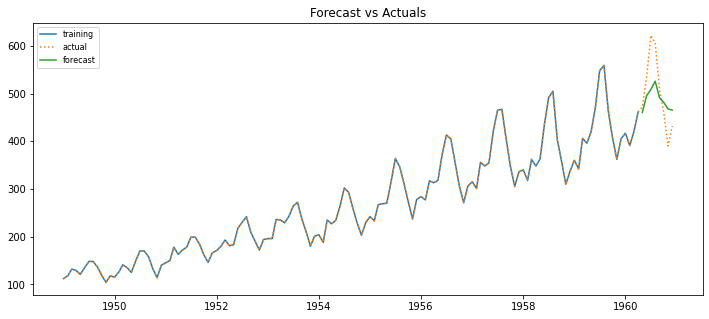

In [22]:
# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train['Month'],train['count'], label='training')
# plt.plot(test['ds'],test['y'] ,label='actual')
plt.plot(data['Month'],data['count'], linestyle=':',label='actual')
plt.plot(test_bak['Month'],test_bak['count'], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error 
mse = mean_squared_error(data['count'][train_size:],test_bak['count'][:])
print('mse=',mse)

mse= 3605.938995829604
